In [1]:
import os
os.getcwd()

'/Users/francopiccolo/GitHub/completion-rate-prediction/notebooks'

In [2]:
os.chdir('../')
os.getcwd()

'/Users/francopiccolo/GitHub/completion-rate-prediction'

In [9]:
import pandas as pd
import numpy as np

In [4]:
# Data load
df = pd.read_csv('./flask/data/completion_rate.csv')

In [5]:
# Preprocessing
df['completion_rate'] = df['submissions'] / df['views']

In [7]:
# Train, val, test, split
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

features = [col for col in df.columns if col.startswith('feat')]
X = df[features]
y = df['completion_rate']

X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, 
                                                    test_size=0.15,
                                                    random_state=42)

X_train, X_val, y_train, y_val = train_test_split(
                                  X_train_val, y_train_val,
                                  test_size=0.15/0.85,
                                  random_state=42)

def get_mean_error(y_true, y_pred):
    error = y_pred - y_true
    abs_error = abs(error)
    return np.mean(abs_error)

In [11]:
# Hyperparam optimization for max_depth and number of estimators
# these are the most important parameters

from itertools import product
import time

import numpy as np


max_depths = [3, 5, 7, 9]
n_estimators = [10, 50, 100]

def try_hyperparam(max_depths, n_estimators)
    for max_depth, n_estimators in product(max_depths, n_estimators):
        random_forest = RandomForestRegressor(max_depth=max_depth,
                                              n_estimators=n_estimators,
                                              n_jobs=4)
        start = time.time()
        random_forest.fit(X_train, y_train)
        end = time.time()
        y_train_pred = random_forest.predict(X_train)
        y_val_pred = random_forest.predict(X_val)
        print('Max depth', max_depth)
        print('N estimators', n_estimators)
        print('Mean train absolute error', get_mean_error(y_train, y_train_pred))
        print('Mean val absolute error', get_mean_error(y_val, y_val_pred))
        print('Training time', end - start)
try_hyperparam(max_depths, n_estimators)

Max depth 3
N estimators 10
Mean train absolute error 0.17774796907455367
Mean val absolute error 0.17742732371944567
Training time 9.323480129241943
Max depth 3
N estimators 50
Mean train absolute error 0.17767236495860997
Mean val absolute error 0.17734721641376341
Training time 43.51104497909546
Max depth 3
N estimators 100
Mean train absolute error 0.17775382725384184
Mean val absolute error 0.17743304108032884
Training time 94.04326820373535
Max depth 5
N estimators 10
Mean train absolute error 0.17520161806006643
Mean val absolute error 0.17486292534809975
Training time 16.105186939239502
Max depth 5
N estimators 50
Mean train absolute error 0.17519272552707504
Mean val absolute error 0.1748571761882717
Training time 67.40108394622803
Max depth 5
N estimators 100
Mean train absolute error 0.17519502596842262
Mean val absolute error 0.17485467401297955
Training time 177.4080662727356
Max depth 7
N estimators 10
Mean train absolute error 0.17361578036082698
Mean val absolute error 

In [16]:
# Increasing estimators doesnt change much max_depth makes more difference
# Try several max_depths greater than 9 which performed best above

max_depths = [10, 20, 30]
n_estimators = [10]
try_hyperparam(max_depths, n_estimators)

Max depth 10
N estimators 10
Mean train absolute error 0.17146029848896197
Mean val absolute error 0.1719476811421716
Training time 27.44524908065796
Max depth 20
N estimators 10
Mean train absolute error 0.1579480743988291
Mean val absolute error 0.17079487623887527
Training time 46.40775012969971
Max depth 30
N estimators 10
Mean train absolute error 0.13820552751121687
Mean val absolute error 0.17292468747273573
Training time 51.451271772384644


In [10]:
# I choose 20 max_Depth and 30 trees
random_forest = RandomForestRegressor(max_depth=20,
                                      n_estimators=30,
                                      n_jobs=4)
random_forest.fit(X_train, y_train)
y_train_pred = random_forest.predict(X_train)
y_test_pred = random_forest.predict(X_test)
print('Mean train absolute error', get_mean_error(y_train, y_train_pred))
print('Mean test absolute error', get_mean_error(y_test, y_test_pred))

Mean train absolute error 0.15739645734068497
Mean test absolute error 0.17031041191857835


In [14]:
# Adjusting prediction to be between 0 and 1
# Doesn't change and makes sense since random forests
# don't extrapolate

def adjust_prediction(prediction):
    prediction = np.where(prediction < 0, 0, prediction)
    prediction = np.where(prediction > 1, 1, prediction)
    return prediction

y_train_pred = adjust_prediction(random_forest.predict(X_train))
y_test_pred = adjust_prediction(random_forest.predict(X_test))
print('Mean train absolute error', get_mean_error(y_train, y_train_pred))
print('Mean test absolute error', get_mean_error(y_test, y_test_pred))

Mean train absolute error 0.15739645734068497
Mean test absolute error 0.17031041191857835


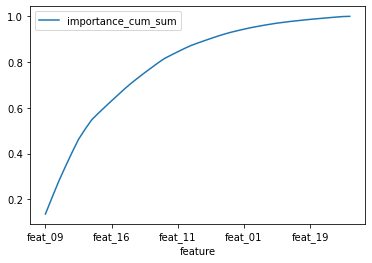

In [23]:
# Feature importances, the importance curve is not steep
# I decide to leave all features in the model

df_feature_importance = pd.DataFrame({'feature': features, 'importance': random_forest.feature_importances_})
df_feature_importance = df_feature_importance.sort_values(by='importance', ascending=False)
df_feature_importance['importance_cum_sum'] = df_feature_importance['importance'].cumsum()
df_feature_importance.plot(x='feature', y='importance_cum_sum')
